<a href="https://colab.research.google.com/github/samuel23taku/NoteBooks/blob/main/Diffusion_With_HuggingFaceDiffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

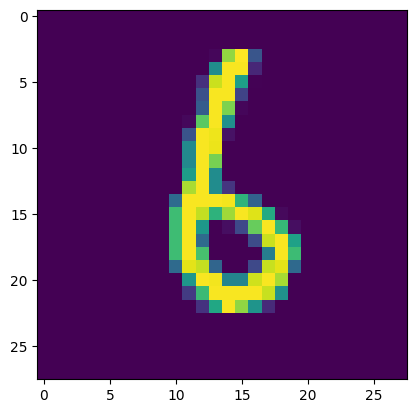

In [18]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    training_data,batch_size=2000,shuffle=True
)
train_features, train_labels = next(iter(train_dataloader))
plt.imshow(train_features[0].squeeze())
plt.show()

## Model

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

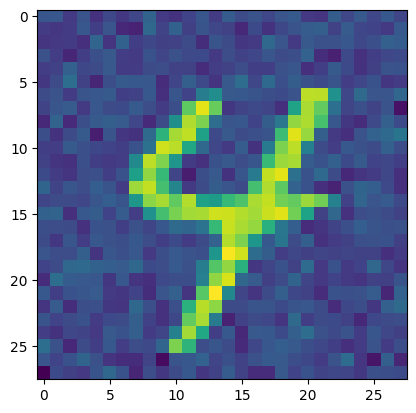

In [2]:
from diffusers import UNet2DModel, DDPMScheduler
from PIL import Image
model = UNet2DModel(
    sample_size = 28,
    in_channels = 1,
    out_channels = 1,
    layers_per_block=2,
        block_out_channels=(32, 64, 128),  # Changed to be divisible by 32
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
   norm_num_groups=1,


)

sample_image = train_features[0].unsqueeze(0)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
time_steps = torch.LongTensor([50]) # create noise for 50th timestep
noise = torch.randn(sample_image.shape)
noisy_image = noise_scheduler.add_noise(sample_image, noise,time_steps)

plt.imshow(noisy_image[0].squeeze(0))
plt.show()
# Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

# Training

In [9]:

from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from tqdm.auto import tqdm
import torch.nn.functional as F


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_dataloader) * 50),
)
global_step = 0


def training_loop(epoches,model,noise_scheduler, optimizer,train_dataloader, lr_scheduler):
  accelerator = Accelerator(
      mixed_precision = "fp16",
      gradient_accumulation_steps=1
  )

  if accelerator.is_main_process:
    accelerator.init_trackers("train_example")

  model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
      model, optimizer, train_dataloader, lr_scheduler
  )

  global_step = 0

  for epoch in range(epoches):
    progress_bar = tqdm(total=len(train_dataloader),disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    for step,batch in enumerate(train_dataloader):
      batch = batch[0].to(accelerator.device)
      noise = torch.randn(batch[0].shape,device=(accelerator.device))
      batch_size = batch[0].shape[0]

      timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,),device=accelerator.device, dtype=torch.int64)

      noisy_images = noise_scheduler.add_noise(batch,noise,timesteps)

      with accelerator.accumulate(model):
        noise_pred = model(noisy_images,timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        accelerator.backward(loss)

        if accelerator.sync_gradients:
          accelerator.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

      progress_bar.update(1)
      logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
      progress_bar.set_postfix(**logs)
      accelerator.log(logs,step=global_step)
      global_step +=1

    if accelerator.is_main_process:
      unwrapped_model = accelerator.unwrap_model(model)
      unwrapped_model.save_pretrained(f"./ModelWeights/epoch_{epoch}")

      # Save optimizer state
      torch.save(optimizer.state_dict(), f"./ModelWeights/epoch_{epoch}/optimizer.pt")

      # Save scheduler state
      torch.save(lr_scheduler.state_dict(), f"./ModelWeights/epoch_{epoch}/scheduler.pt")

  accelerator.end_training()


torch.cuda.empty_cache()
training_loop(8,model,noise_scheduler,optimizer, train_dataloader,lr_scheduler)



  0%|          | 0/30 [00:00<?, ?it/s]

<ipython-input-9-1c8fe25254e2>:46: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([2000, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred, noise)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

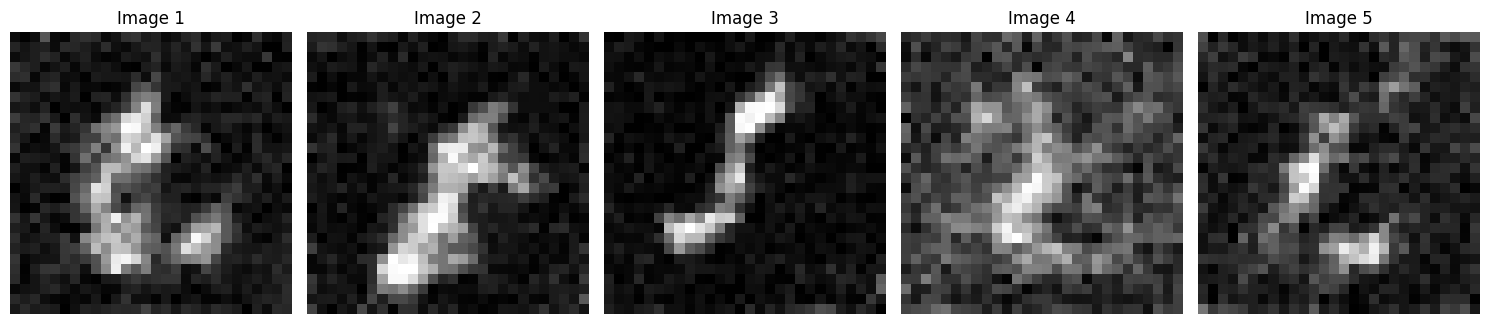

In [23]:
from diffusers import UNet2DModel
from transformers import get_scheduler
import torch
def denormalize(image, mean=0.5, std=0.5):
    """Denormalize the image."""
    return image * std + mean

def sample_from_model(model, noise_scheduler, num_samples=1, image_size=28, num_inference_steps=50, device="cuda"):
    # Initialize random noise
    x = torch.randn(num_samples, model.config.in_channels, image_size, image_size, device=device)

    # Sampling loop
    for t in noise_scheduler.timesteps:
        # Get the model prediction
        with torch.no_grad():
            noise_pred = model(x, t).sample

        # Update sample with scheduler step
        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    # Denormalize images
    x = denormalize(x, mean=0.5, std=0.5)

    # Clip values to [0, 1] range
    x = torch.clamp(x, 0, 1)

    return x.cpu()

# Sample from the model
num_samples = 5
sampled_images = sample_from_model(model, noise_scheduler, num_samples=num_samples, image_size=28, device=device)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    # Get the i-th image
    img = sampled_images[i].squeeze().cpu().numpy()

    # Display the image
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()
